In [33]:
import os
import glob

In [34]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from datetime import datetime

In [35]:
#Import the data

# path = r"C:\Users\Jae\Desktop\Cafe Project"
# allFiles = glob.glob(os.path.join(path,"*.csv"))

# df_from_each_file = (pd.read_csv(f) for f in allFiles)
# all_sales   = pd.concat(df_from_each_file, ignore_index=True)
all_sales = pd.concat([pd.read_csv('The Cafe 2017 Sales.csv'),pd.read_csv('The Cafe 2018 Sales.csv')])

In [36]:
all_sales.head()

,Date,Time,Time Zone,Category,Item,Qty,Price Point Name,SKU,Modifiers Applied,Gross Sales,Discounts,Net Sales,Tax,Dining Option,Customer ID,Customer Name,Customer Reference ID
0,12/31/17,16:01:36,Pacific Time (US & Canada),Coffee,Americano,1,"Small, 12 oz",NaN,NaN,$2.65,$0.00,$2.65,$0.13,To Go,NaN,NaN,NaN
1,12/31/17,16:01:36,Pacific Time (US & Canada),Coffee,Macchiato,1,4 oz (trad),NaN,Decaf,$3.50,$0.00,$3.50,$0.18,To Go,NaN,NaN,NaN
2,12/31/17,15:47:59,Pacific Time (US & Canada),Tea,Tea,1,English Breakfast,NaN,NaN,$2.60,$0.00,$2.60,$0.13,To Go,NaN,NaN,NaN
3,12/31/17,15:47:59,Pacific Time (US & Canada),Coffee,Americano,1,"Small, 12 oz",NaN,NaN,$2.65,$0.00,$2.65,$0.13,To Go,NaN,NaN,NaN
4,12/31/17,15:47:59,Pacific Time (US & Canada),Coffee,Latte,1,"Small, 12 oz",NaN,NaN,$3.80,$0.00,$3.80,$0.19,To Go,NaN,NaN,NaN


Cleaning the data

In [37]:
#Remove useless columns
for col in ['SKU','Customer ID', 'Customer Name', 'Customer Reference ID']:
    all_sales.drop(columns = col, inplace = True)
    

In [38]:
#Remove the dollar signs from select columns and convert to float
for col in ['Gross Sales', 'Discounts', 'Net Sales', 'Tax']:
    all_sales[col] = all_sales[col].str.replace('$','', regex = False)
    all_sales[col] = all_sales[col].astype('float64')

    

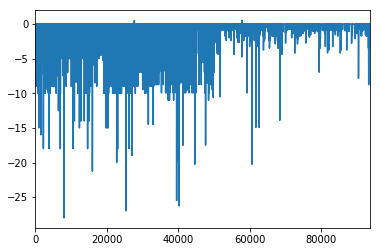

In [39]:
#A quick plotting of discounts shows two outliers: positive discounts
all_sales['Discounts'].plot()

In [40]:
#There are a couple 'negative' sales with negative quantity, negative sale, positive discount, etc (all signs switched)
#Fix them by flipping signs.

select_columns = all_sales.select_dtypes(include=['number']).columns
condition = all_sales['Discounts']>0
all_sales.loc[condition, select_columns] *= -1

In [41]:

#For the dates that mistakenly took the first months as years, remove the 20
all_sales.loc[all_sales['Date'].str.len()>8,'Date'] = [x[2:] for x in all_sales.loc[all_sales['Date'].str.len()>8]['Date']]
all_sales['Date'] = all_sales[all_sales['Date'].notnull()]

In [42]:
#Identify the products that are not categorized
all_sales[all_sales['Category']== 'None']['Item'].unique()

array(['Day old', 'Custom Amount', 'Christmas Things', 'Kids Stuff',
       'Laminated Pastries', 'Fridge Drinks', 'Mocha', 'Juices',
       'Americano', 'Pies', 'Espresso', 'Homemade Hot Chocolate', 'Chai',
       'Sausage Roll', 'London Fog', 'Quiche ', 'Weekly Special (Voided)',
       'Custom Amount (Voided)', 'Burger buns', 'Weekly Special',
       'Dome Cake', 'Latte', 'Delivery Fee'], dtype=object)

In [43]:
#Identify unique categries
all_sales['Category'].unique()

array(['Coffee', 'Tea', 'Food', 'Breakfast', 'Misc Drinks', 'Lunch',
       'Pastries', 'Hot breakfast', 'None', 'Grab And Go', 'Merch'],
      dtype=object)

In [44]:
#Change burger buns to Burger Buns, etc
all_sales.loc[all_sales['Item']== 'burger buns', 'Item'] = 'Burger Buns'
all_sales.loc[all_sales['Item']== 'Burger buns', 'Item'] = 'Burger Buns'
all_sales.loc[all_sales['Item']== 'Quiche ', 'Item'] = 'Quiche'

In [45]:
#Alerted the manager of uncategorized products
#Categorize according to the manager's instructions
categorization = {'Day old':'Food',
                'Custom Amount':'Misc',
                'Christmas Things':'Pastries',
                'Kids Stuff':'Misc Drinks',
                'Laminated Pastries':'Pastries',
                'Fridge Drinks':'Misc Drinks',
                'Mocha':'Coffee',
                'Juices':'Misc Drinks',
                'Americano':'Coffee',
                'Pies':'Food',
                'Espresso':'Coffee',
                'Homemade Hot Chocolate':'Coffee',
                'Chai':'Tea',
                'Sausage Roll':'Pastries',
                'London Fog':'Tea',
                'Quiche':'Food',
                'Weekly Special (Voided)':'Voided',
                'Custom Amount (Voided)':'Voided',
                'Burger Buns':'Food',
                'Weekly Special':'Food',
                'Dome Cake':'Food',
                'Latte':'Coffee',
                'Delivery Fee':'Delivery Fee',
                'Dome Cake (Voided)':'Voided',
                'Sausage Roll (Voided)':'Voided'
}
for item in all_sales[all_sales['Category']== 'None']['Item'].unique():
    if categorization[item]:
        all_sales.loc[all_sales['Item']==item,'Category'] = categorization[item]
    else:
        raise Exception("There's an uncategorized item!")



In [46]:
#There are modifiers applied that are null but are there any other values that are null?
condition = all_sales['Modifiers Applied'].notnull()
all(all_sales.loc[condition,all_sales.columns].notnull())

True

In [47]:
#Just combine date and time. Uniformize the format before converting to datetime series.
all_sales['Date']= all_sales['Date']+' '+all_sales['Time']
all_sales = all_sales.drop('Time', axis=1)
all_sales['Date']=all_sales['Date'].str.replace('-','/')
all_sales['Date']=pd.to_datetime(all_sales['Date'],format='%m/%d/%y %H:%M:%S')


In [48]:
# all_sales['Date']=pd.Timestamp(all_sales['Date'])

In [49]:
#Set the new datetime series as the index.
all_sales.index=all_sales['Date']
all_sales = all_sales.drop(['Date'],axis=1)

In [50]:
#Sort chronologically
all_sales.sort_index(inplace=True)

In [51]:
#Save the clean data
all_sales.to_csv('Clean Sales (2017-2018).csv')